# Model Analysis

This notebook summarizes various measures of model performance.

Each model was trained on a dataset of simulated 64x64 pixel camera input, with different telemetry data included. Though different train/test splits were tried, all of the succesful models used a 0.9/0.1 train/test split.

Of 190 trained models constructed, 12 were able to complete two or more simultaneous laps. Each of these was then given 5 test runs, with their full telemetry recorded.

Of these 12 models, 3 failed to complete a single lap in any of the 5 trials. Each of the remaing 9 were able to complete at least one lap in at least 2 of their 5 trials.

### Model Stat Columns

|Name|Type|Description|
|:---|:---|:---|
| **ID** |integer|model id number|
| **batch** |integer|batch sized for model fitting|
| **output** |tuple|output layer configuration: single two-node output or two parallel one-node outputs|
| **telemetry** |list|telemetry data used at model input|see telemetry table|
| **scaler** |function|type of scaler used to fit and transform telemetry data|StandardScaler(), MinMaxScaler()|
| **total_laps** |continuous|combined total of complete and partial laps over all five trials||
| **avg_speed** |conitnius|average speed over all five trials, completed laps only (meters per second)|
| **avg_lap** |continuous|average lap time over all five trials, completed laps only (seconds)
| **mse** |continous|model's validation mean squared error score||
| **mae** |continous|model's validation mean absolute errror score||




### Telemetry Data Types
Additional telemetry data were tested; these types were used by the successful models.

|Name|Data Type|Units|Description|
|:---|:---|:---|:---|
|**activeNode**|ordinal|-|current track segment, 307 total|
|**pitch**|continuous|fegrees|longitudinal ('lengthwise') tilt|
|**pos_x**|continuous|meters|x coordinate on track plane|
|**pos_z**|continuous|meters|y coordinate on track plane*|
|**roll**|continuous|fegrees|latitudinal ('widthwise') tilt|
|**speed**|continuous|meters/second|combined velocity|
|**yaw**|continuous|degrees|heading|

\* Note: In the simulator's coordinate system, the raw 'z' value, here, is the 'y' coordinate.  
Table code generated with [Tables Generator](https://www.tablesgenerator.com/markdown_tables)

### Models Stats


|ID|Batch|Output|Scaler|Telmetry Data|Total Laps|Avg Time|Avg Speed|MSE|MAE|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| **131** |128|combined|MinMax|activeNode, pitch, roll, speed, yaw|10.735|46.71|11.89|0.021433|0.068281
| **141** |32|combined|Standard|activeNode, pitch, pos_x, pos_z, roll, speed, yaw|17.846|45.30|12.20|0.021409|0.068000|
| **143** |128|combined|Standard|activeNode, pitch, pos_x, pos_z, roll, speed, yaw|6.717|44.67|12.22|0.021148|0.066184|
| **152** |1024|dual|MinMax|activeNode, pitch, pos_x, pos_z, roll, speed, yaw|1.704|-|-|0.011346|0.069824|
| **157** |512|dual|Standard|activeNode, pitch, pos_x, pos_z, roll, speed, yaw|10.675|46.78|11.84|0.010954|0.067489|
| **166** |2048|combined|Standard|pos_x, pos_z, speed, yaw|17.039|46.70|11.78|0.021574|0.070265|
| **170** |128|combined|MinMax|pos_x, pos_z, speed, yaw|5.846|48.25|11.60|0.021633|0.065321|
| **171** |256|combined|MinMax|pos_x, pos_z, speed, yaw|1.479|-|-|0.021911|0.068060|
| **172** |512|combined|MinMax|pos_x, pos_z, speed, yaw|5.105|45.83|12.30|0.022221|0.068652|
| **173** |1024|combined|MinMax|pos_x, pos_z, speed, yaw|0.674|-|-|0.021904|0.068440|
| **176** |32|dual|Standard|pos_x, pos_z, speed, yaw|8.644|46.79|11.74|0.011026|0.066307|
| **178** |128|dual|Standard|pos_x, pos_z, speed, yaw|22.004|43.99|12.61|0.010295|0.063061|

## Visualiztion

In [12]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### Load Model Data

In [2]:
models = pd.read_pickle('../data/model_parameters.pkl')
telem_columns = ['activeNode', 'pitch', 'pos_x', 'pos_z', 'roll', 'speed', 'yaw']
models.drop(columns=telem_columns, inplace=True)
trial_data = pd.read_pickle('../data/trial_stats.pkl')
model_ids = list(trial_data.keys())
model_ids

[131, 141, 143, 152, 157, 166, 170, 171, 172, 173, 176, 178]

In [3]:
## Look at models' trial progressa
for model in model_ids:
    models.loc[models['id']==model, 'total_laps'] = round(sum(trial_data[model][f'trial_{t}']['laps'] for t in range(1,6)),3)
    speeds = []
    avg_laps = []
    for t in range(1,6):
        if trial_data[model][f'trial_{t}']['laps'] > 1:
            speeds.append(trial_data[model][f'trial_{t}']['avg_speed'])
            avg_laps.append(trial_data[model][f'trial_{t}']['avg_lap'])
    if len(speeds) > 0:
        models.loc[models['id']==model, 'avg_speed'] = round(np.mean(speeds), 2)
        models.loc[models['id']==model, 'avg_lap'] = round(np.mean(avg_laps), 2)
    for metric in ['mse', 'mae']: #, 'rmse']:
        score = trial_data[model][metric][1:-1].split(sep=',')
        if models.loc[models['id']==model, 'output'].items() == 'd':
            score = np.mean([ float(s) for s in score ])
        else:
            score = float(score[0])
        models.loc[models['id']==model, metric] = score

### Plot total laps for all models

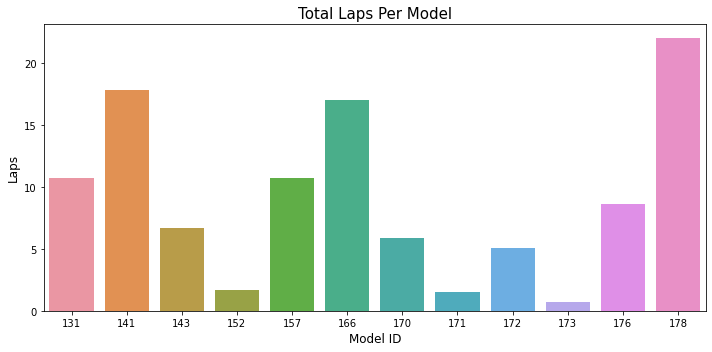

In [4]:
fig = plt.figure(figsize=(10,5))

sns.barplot(data=models, x='id', y='total_laps')
plt.title('Total Laps Per Model', size=15)
plt.ylabel('Laps', size=12)
plt.xlabel('Model ID', size=12)
plt.tight_layout()

### Remove outliers

In [5]:
top_models = models.loc[models['avg_speed']>0, :]
top_models.reset_index(drop=True, inplace=True)

### Plot average speed

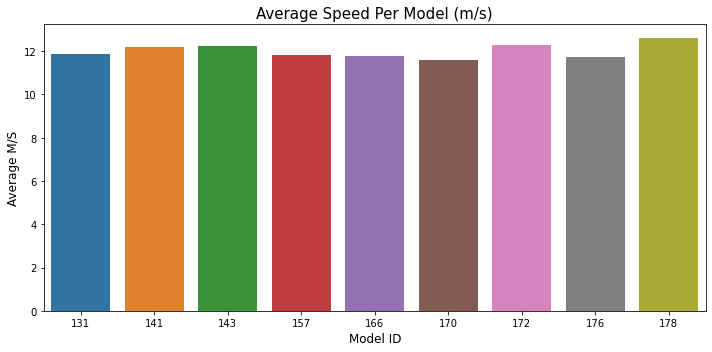

In [6]:
fig = plt.figure(figsize=(10,5))
sns.barplot(data=top_models, x='id', y='avg_speed')
plt.title('Average Speed Per Model (m/s)', size=15)
plt.ylabel('Average M/S', size=12)
plt.xlabel('Model ID', size=12)
plt.tight_layout()

*Analysis*:
* There appears to be little difference in average speed.

### Plot trial metrics vs scaler type and output configuration 

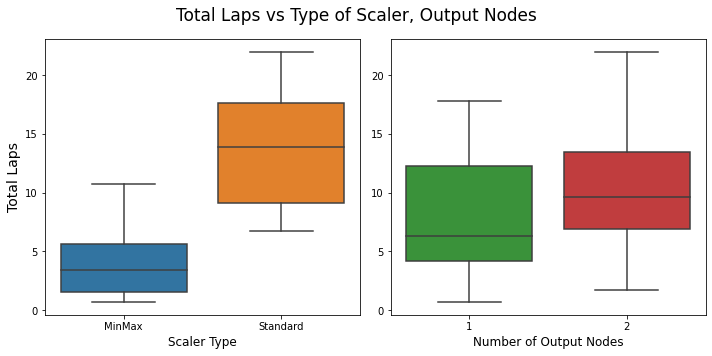

In [10]:
# sns.set_style('white')

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.suptitle('Total Laps vs Type of Scaler, Output Nodes', 
             size=17)

ax[0] = sns.boxplot(data=models, x='scaler', y='total_laps', 
                    ax=ax[0], palette=sns.color_palette()[0:])
ax[0].set_xlabel('Scaler Type', size=12)
ax[0].set_ylabel('Total Laps', size=14)
ax[0].set_xticklabels(['MinMax', 'Standard'], size=10)
ax[0].tick_params(axis='y', labelsize=10)

ax[1] = sns.boxplot(data=models, x='output', y='total_laps', 
                    ax=ax[1], palette=sns.color_palette()[2:])
ax[1].set_xlabel('Number of Output Nodes', size=12)
ax[1].set_ylabel('')
ax[1].set_xticklabels(['1', '2'], size=10)
ax[1].tick_params(axis='y', labelsize=10)

    
plt.tight_layout();

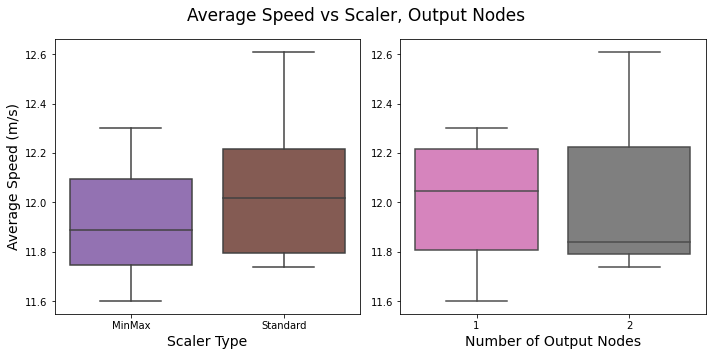

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.suptitle('Average Speed vs Scaler, Output Nodes', 
             size=17)

ax[0] = sns.boxplot(data=models, x='scaler', y='avg_speed', 
                    ax=ax[0], palette=sns.color_palette()[4:])
ax[0].set_xlabel('Scaler Type', size=14)
ax[0].set_ylabel('Average Speed (m/s)', size=14)
ax[0].set_xticklabels(['MinMax', 'Standard'], size=10)
ax[0].tick_params(axis='y', labelsize=10)

ax[1] = sns.boxplot(data=models, x='output', y='avg_speed', 
                    ax=ax[1], palette=sns.color_palette()[6:])
ax[1].set_xlabel('Number of Output Nodes', size=14)
ax[1].set_ylabel('', size=12)
ax[1].set_xticklabels(['1', '2'], size=10)
ax[1].tick_params(axis='y', labelsize=10)


plt.tight_layout();

*Analysis*:
* The type of scaler used seems to have some effect on total laps completed, but there is far too little data to draw any real conclusions.

### Plot correlations

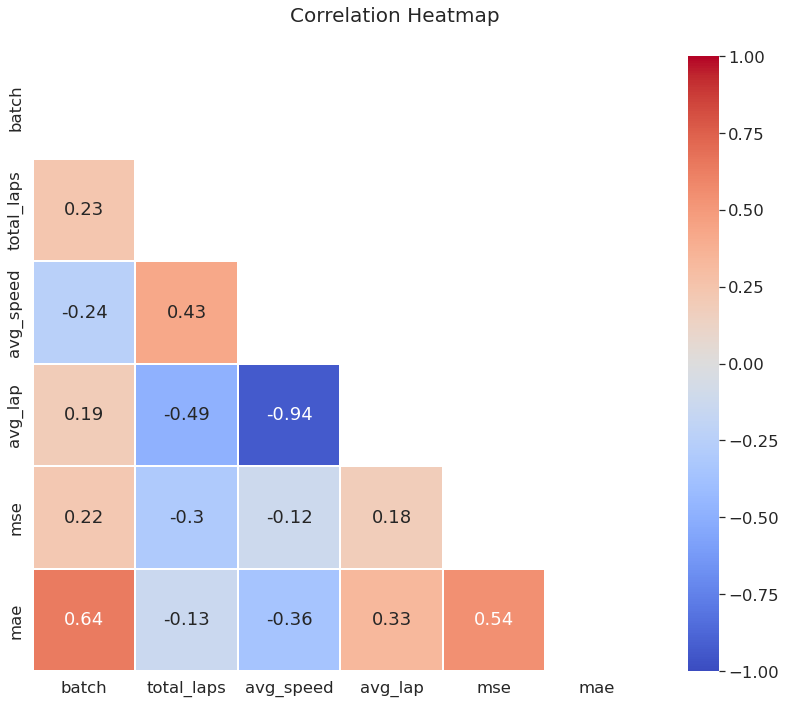

In [93]:
# fig = plt.figure(figsize=(12,12))
corr = top_models.drop(columns='id').corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.5)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(corr, 
                     mask=mask, 
                     square=True, 
                     vmin=-1.0, 
                     vmax=1.0, 
                     linewidths=0.1, 
                     annot=True, cmap='coolwarm')#, annot_kws={"size": 15} )
plt.suptitle('Correlation Heatmap', size=20)
plt.tight_layout();

*Analysis*:   
* Larger batch sides seemed to have a positive correlation with all but average speed.  
* The most interesting relationship is the negative correlation between the average lap time and the total number of laps completed: it would seem that the slower models were also the most consistent performers.

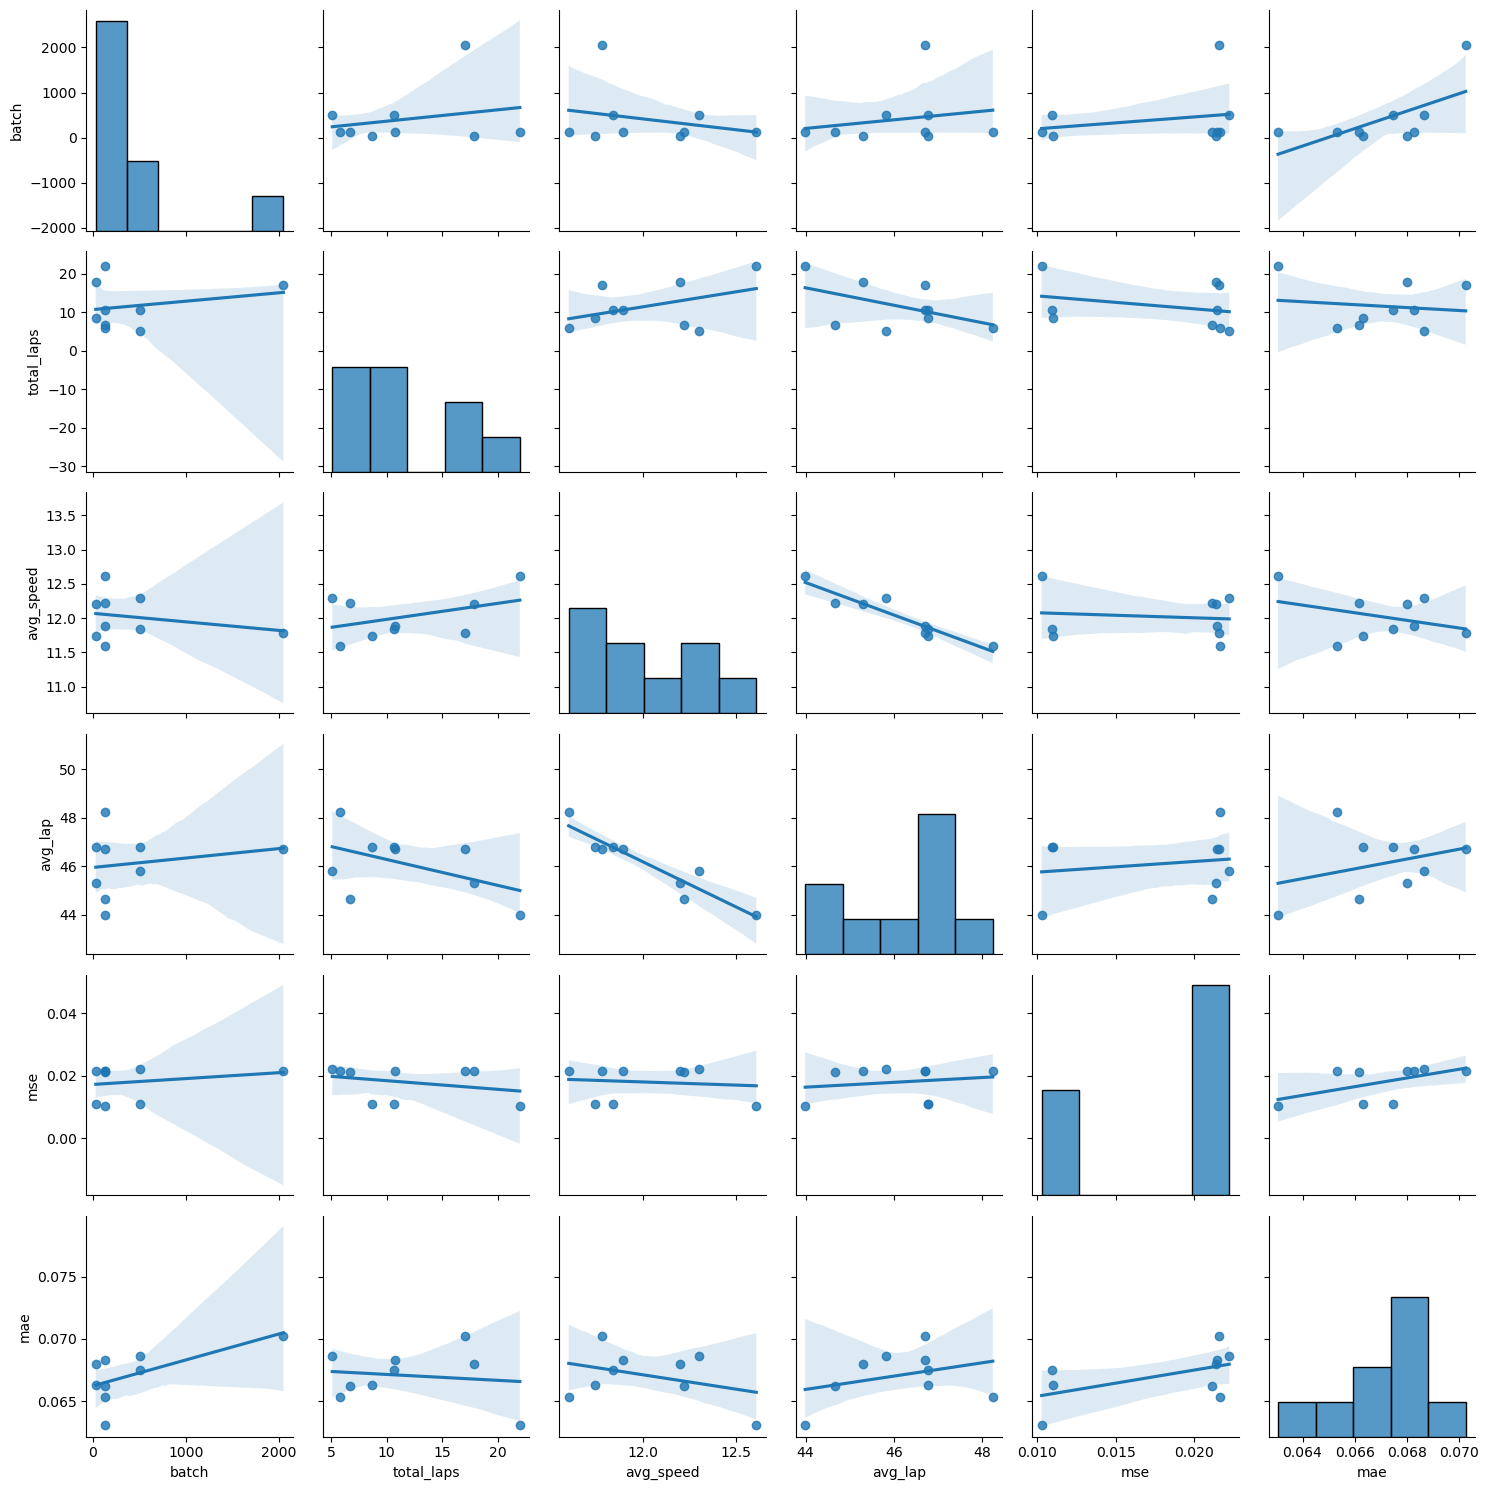

In [25]:
mlp.style.use('default')
sns.pairplot(top_models.drop(columns='id'), kind='reg')
plt.tight_layout();

*Analysis*: 
* This pairwise plot succinctly illustrates the sparseity of the data.

## Conclusion
* Though there are minor differences in model trial performance, there simply iesn't enough data to draw meaningful conclusions.